In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [195]:
x = np.load("TimeDelayData/pairs_with_truths_and_windows.npz")['arr_0']


In [206]:
pair_ids = np.unique(x['full_pair_id'])
quad_pair_ids = pair_ids[pair_ids % 1.0 == 0.5] # Finde file A of a quadratic system
quad_pair_ids = np.append(quad_pair_ids, quad_pair_ids - 0.5) # Finds file B of the same quadratic system
pair_ids = np.setdiff1d(pair_ids, quad_pair_ids) # Removes all quadratic systems from pair_ids
# Fit GP model to each sampling window of the data separately


In [207]:
x = x[np.in1d(x['full_pair_id'], pair_ids)]

In [334]:
def normalize(w):
    t = w['time']; t = t - t.min();
    dt = w['dt'][0]
    dt = dt / t.max()
    t = t / t.max()
    lcA = w['lcA']; lcA = lcA - lcA.mean(); lcA = lcA / lcA.std()
    lcB = w['lcB']; lcB = lcB - lcB.mean(); lcB = lcB / lcB.std()
    h = max(lcA.max() - lcA.min(), lcB.max() - lcB.min()) / 2.
    lcA = lcA / h
    lcB = lcB / h
    return t, lcA, lcB, dt
    
def clamp(x, min, max):
    x = np.where(x>max, max, x)
    x = np.where(x<min, min, x)
    return x

def drawgrid(grid, x, y):
    # Assumes x in ]-1, 1[ and y in ]-1,1[
    h, w = grid.shape
    x = clamp(np.floor(w * (x + 1.) / 2.).astype(int), 0, w-1)
    y = clamp(np.floor(h * (y + 1.) / 2.).astype(int), 0, h-1)
    grid[y, x] = 1
    return grid


def drawgrid_at_offset(grid, x, y1, y2, dx):
    # x in ]0,1[
    # y1, y2 in ]-1,1[
    # dx in ]-1,1[
    return drawgrid(drawgrid(grid, x+dx/2.-.5, y1), x-dx/2.-.5, y2)

def gridfit(grid, x, y1, y2, dx):
    return float(grid.shape[1]) / float(drawgrid_at_offset(grid, x, y1, y2, dx).sum()) - 1.0

def gridfitall(w, h, x, y1, y2):
    offsets = np.linspace(-1, 1, w)
    fits = np.zeros(len(offsets))
    for i in xrange(0, len(offsets)):
        fits[i] = gridfit(zeros((h, w)), t, lcA, lcB, offsets[i])
    return offsets, fits

def gridsizefit(minw, maxw, minh, maxh, x, y1, y2):
    infocontent = zeros((maxh - minh, maxw - minw))
    for wi, w in enumerate(xrange(minw, maxw)):
        for hi, h in enumerate(xrange(minh, maxh)):
            offsets, fits = gridfitall(w, h, x, y1, y2)
            infocontent[hi,wi] = fits.max() - fits.mean()
    return infocontent
    

In [321]:
wids = np.unique(x['window_id'])
t, lcA, lcB, dt = normalize(x[x['window_id'] == wids[1]])

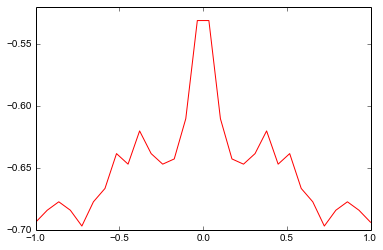

In [322]:
offsets = np.linspace(-1, 1, 30)
fits = np.zeros(len(offsets))
for i in xrange(0, len(offsets)):
    fits[i] = gridfit(zeros((10, 30)), t, lcA, lcA, offsets[i])

plt.plot(offsets, fits, 'r-')
plt.show()        
    

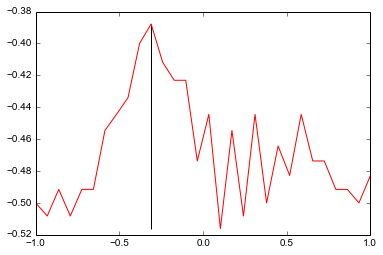

In [327]:
wids = np.unique(x['window_id'])
t, lcA, lcB, dt = normalize(x[x['window_id'] == wids[10000]])

offsets, fits = gridfitall(30, 10, t, lcA, lcB)

plt.plot(offsets, fits, 'r-')
plt.vlines(dt, fits.min(), fits.max())
plt.show()

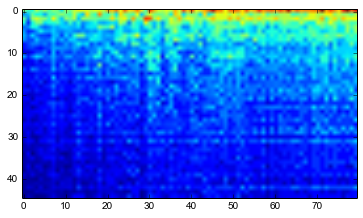

In [335]:
imshow(gridsizefit(20, 200, 5, 20, t, lcA, lcB), cmap='Greys')
